In [15]:
import configparser


In [16]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook



In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
config = configparser.ConfigParser()
config.read("config.ini")
name = str(config['Files']['file']) 

Зчитування даних

In [20]:
df = pd.read_json(name  + ".json" )

In [21]:
df = df[["date","message"]]
df

,date,message
0,2023-01-12 18:28:01+00:00,
1,2023-01-12 18:28:00+00:00,У нас радость!! Собрали целых две газели гумма...
2,2023-01-12 07:33:05+00:00,
3,2023-01-12 07:33:05+00:00,
4,2023-01-12 07:33:05+00:00,
...,...,...
995,2022-08-05 05:41:59+00:00,"Мы в ОПСБ делаем то, что делаем, не ради медал..."
996,2022-08-04 20:49:58+00:00,Из жизни паховых гнид
997,2022-08-04 18:25:59+00:00,Хорошие новости с Артемовского направления. ЧВ...
998,2022-08-04 14:04:59+00:00,Сегодня 4 августа печальная годовщина не тольк...


In [22]:
df["date"] = df["date"].dt.strftime('%Y-%m-%d')

In [23]:
df.head(10)

,date,message
0,2023-01-12,
1,2023-01-12,У нас радость!! Собрали целых две газели гумма...
2,2023-01-12,
3,2023-01-12,
4,2023-01-12,
5,2023-01-12,"З00 разгрузок + теплая форма,берцы,печки 10шт,..."
6,2023-01-07,С Рождеством!
7,2023-01-06,
8,2023-01-06,Попытки дискредитации или вызвать разлад в сое...
9,2023-01-05,


In [24]:

reindexed_data = df["message"]
reindexed_data.index = df['date']

reindexed_data = reindexed_data.dropna()
reindexed_data

date
2023-01-12                                                     
2023-01-12    У нас радость!! Собрали целых две газели гумма...
2023-01-12                                                     
2023-01-12                                                     
2023-01-12                                                     
                                    ...                        
2022-08-05    Мы в ОПСБ делаем то, что делаем, не ради медал...
2022-08-04                                Из жизни паховых гнид
2022-08-04    Хорошие новости с Артемовского направления. ЧВ...
2022-08-04    Сегодня 4 августа печальная годовщина не тольк...
2022-08-04                                                     
Name: message, Length: 1000, dtype: object

In [25]:
# Define helper functions
def get_top(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0] for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

Препроцесинг

In [26]:
#тут ми імпортуємо словар стоп слів, ми його розишир
stop_words = stopwords.words('russian')
stop_words.extend(["это","як","ещё","це", "але", "що", "nevzorovtv","com","всё","весь","наш","свой","все","https", "me", "которые", "который"])
stop_words 

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [27]:

from string import punctuation

#тут ми робимо препроцесинг
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from nltk.corpus import stopwords
#тут робиться лематизація
def lemmatize(words):
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

#токенізація
def preprocessing(line):
    tokenize = word_tokenize(line.lower(), language = "russian")
    lem = lemmatize(tokenize)
    ## фильтрация на стоп слова и на пунктуацію
    res = list(filter(lambda w: w not in stop_words and w not in punctuation, lem))

    return " ".join(res)

In [28]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
reindexed_data = reindexed_data.apply(preprocessing)

In [30]:
#як виглядає перша строка після всього
new_data = reindexed_data.apply(preprocessing)
new_data[0]

''

In [31]:
new_data[119:].head(10)

date
2022-12-11    друг боец попросить купить рация азарт наслать...
2022-12-11                                                     
2022-12-10                            увидеть камедь клаб гость
2022-12-10            туалет едва выдержать волна взрыв топоров
2022-12-10                                                     
2022-12-10    вчера узнать погибнуть друг радик пуля знать «...
2022-12-09    заезжать гость прапор тёплый пальтишко тёплый ...
2022-12-09    друг собрать нужный сумма накидка спасибо боль...
2022-12-09    испания перечитывать книга время испания влады...
2022-12-09    инструкция вести здание время обрушение нужно ...
Name: message, dtype: object

In [32]:
reindexed_data.to_csv("output/new.csv")

Зчитування з файлу дата

In [33]:
# new_data = pd.read_csv("./output/test2.csv")
# new_data
# далі читаємо весь датасет, який вже пройшов препроц,
data = pd.read_csv("./output/new.csv")
data

,date,message
0,2023-01-12,NaN
1,2023-01-12,радость собрать целый газель гумманитарный пом...
2,2023-01-12,NaN
3,2023-01-12,NaN
4,2023-01-12,NaN
...,...,...
995,2022-08-05,опсб делать делать ради медаль благодарность н...
996,2022-08-04,жизнь паховой гнида
997,2022-08-04,хороший новость артёмовский направление чвк ``...
998,2022-08-04,сегодня 4 август печальный годовщина `` особый...


In [34]:
readed = pd.read_csv("./output/nev.csv")
readed

,date,message
0,2022-11-20,пленный новосибирск просить правительство поме...
1,2022-11-20,смотреть новый выпуск программа наповал //yout...
2,2022-11-20,очень эффектно выглядеть лозунг колорадский ле...
3,2022-11-20,NaN
4,2022-11-20,NaN
...,...,...
991,2022-08-25,🖍 невзоров помимо прочее следствие война понят...
992,2022-08-25,🖍 « рыпаться » шуметь « спасать » фабрика малы...
993,2022-08-25,🖍 приметам- накладка недосмотр персонал прямой...
994,2022-08-24,александр невзоров невзоровский среда питер за...


In [35]:
#data  = readed.append(new_data, ignore_index=True)
#data  = data.append(readed, ignore_index=True)
# костиль уберет пустіе строки, если они еще есть 
data  = data.dropna()
data 

,date,message
1,2023-01-12,радость собрать целый газель гумманитарный пом...
5,2023-01-12,з00 разгрузка тёплый форма берцы печка 10шт су...
6,2023-01-07,рождество
8,2023-01-06,попытка дискредитация вызвать разлад соя семья...
11,2023-01-05,спасибо
...,...,...
990,2022-08-05,сводка '' пограничный фронт '' граница белорус...
995,2022-08-05,опсб делать делать ради медаль благодарность н...
996,2022-08-04,жизнь паховой гнида
997,2022-08-04,хороший новость артёмовский направление чвк ``...


In [36]:
reindexed_data = data["message"]
reindexed_data.index = data['date']

reindexed_data

date
2023-01-12    радость собрать целый газель гумманитарный пом...
2023-01-12    з00 разгрузка тёплый форма берцы печка 10шт су...
2023-01-07                                            рождество
2023-01-06    попытка дискредитация вызвать разлад соя семья...
2023-01-05                                              спасибо
                                    ...                        
2022-08-05    сводка '' пограничный фронт '' граница белорус...
2022-08-05    опсб делать делать ради медаль благодарность н...
2022-08-04                                  жизнь паховой гнида
2022-08-04    хороший новость артёмовский направление чвк ``...
2022-08-04    сегодня 4 август печальный годовщина `` особый...
Name: message, Length: 710, dtype: object

тут виводимо Найбільш популярні слова 

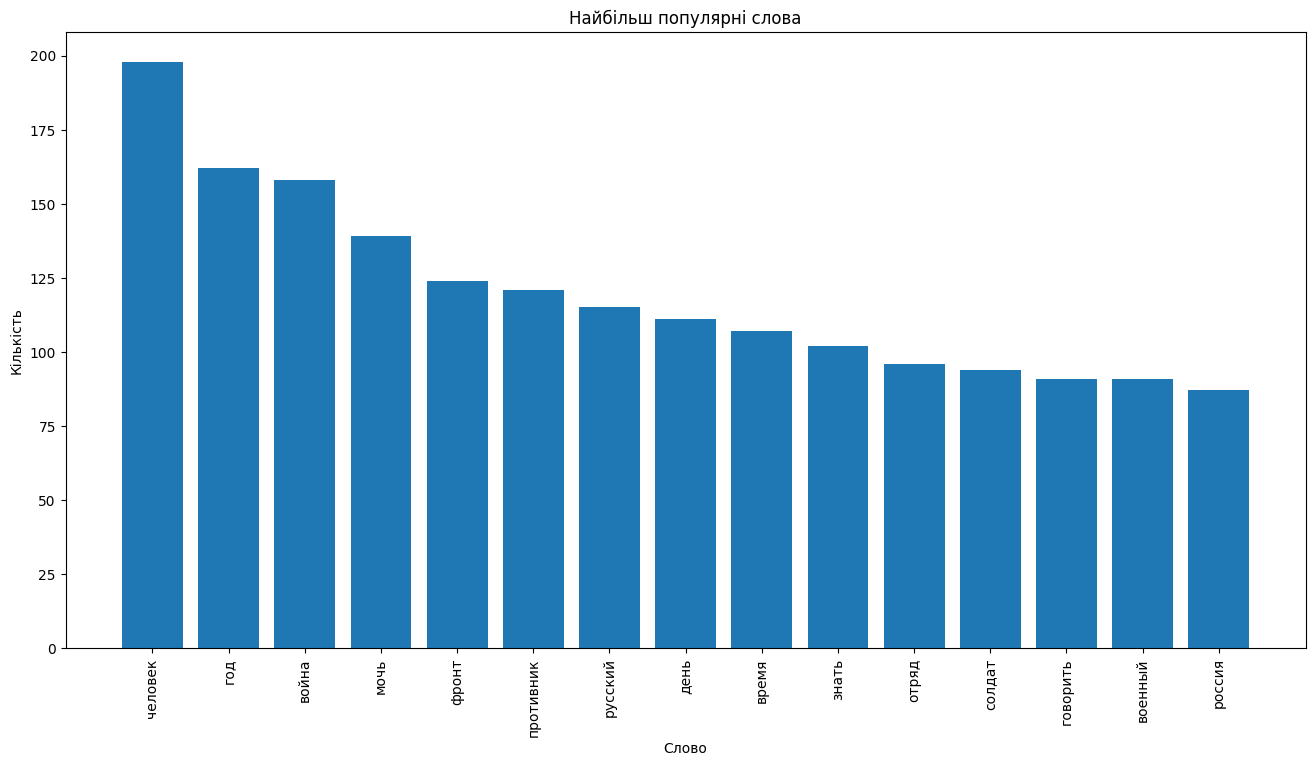

In [37]:

count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Найбільш популярні слова');
ax.set_xlabel('Слово');
ax.set_ylabel('Кількість');
plt.show()

In [38]:
# Прибрати вплив загальної теми каналів
# додаю стоп слова найбільш популярними словами, щоб обрати головну тему
stop_words.extend(words)
stop_words

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

Розподіл кількості постів за часом

In [39]:
#будуємо графік постів за місяць і за 3-4 міс
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]


In [40]:
#скілько всього у нас було слів, та середню довж поста
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  34311
Mean number of words per headline:  48.32535211267606


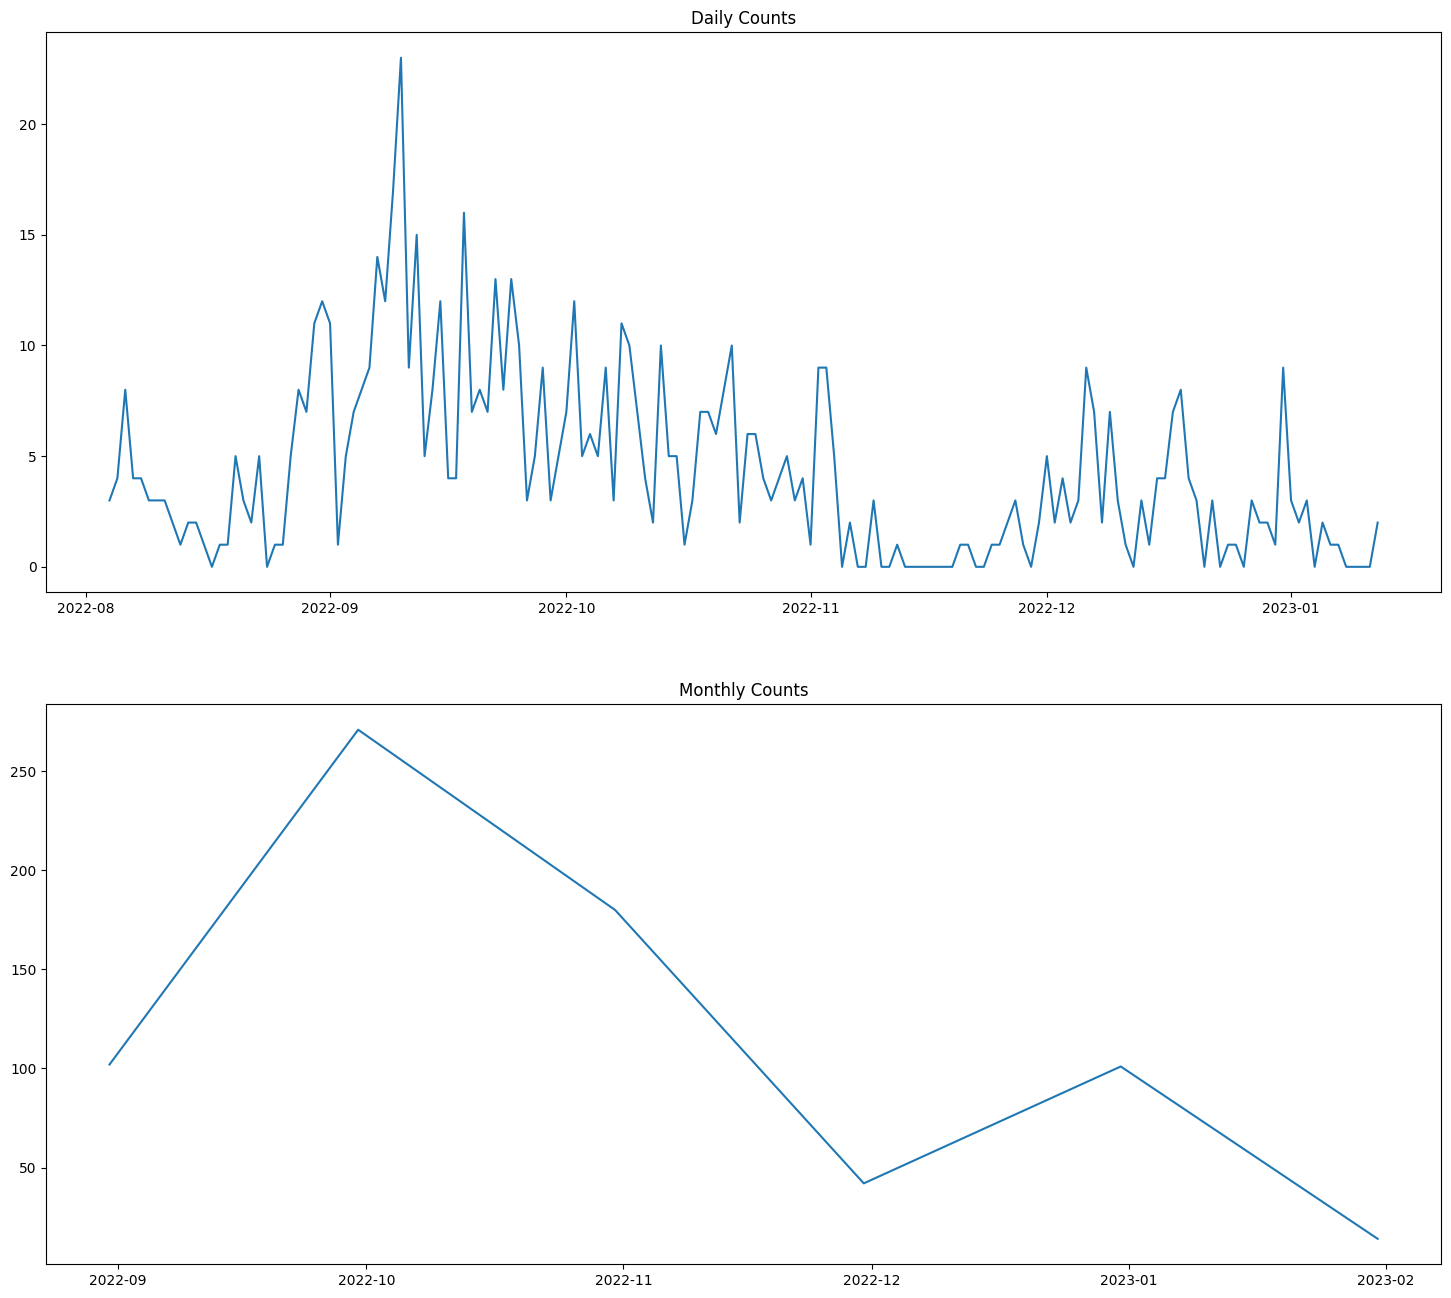

In [41]:
#Перед вами розподіл постів за часом для телеграм
reindexed_data.index = pd.to_datetime(reindexed_data.index)
monthly_counts = reindexed_data.resample('M').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(2, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
plt.show()

## Topic modelling

Маленька вибірка - до 1000 постів 
Велика вибірка - 2000 - 4000 постів

In [42]:
small_count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
small_text_sample = reindexed_data.sample(n=200, random_state=1).values

print('Пост: {}'.format(small_text_sample[23]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Результат ембедінгу: \n{}'.format(small_document_term_matrix[23]))

Пост: и.и. стрелок гранит первый бросаться глаз человек купить цена знать лично ранее пытаться назначить сумма подкуп готовый поспорить желать немало основание сломать зуб идейность принципиальность последовательность неподкупность удивительный жёсткость жестокость важно человек знать лично прийти голова назвать милый человек невозможно договориться идти чуть-чуть вразрез представление ситуация слушать стать стрелок уметь брать ответственность бояться самый главное уметь создать вокруг структура каждый винтик знать место навести порядок хаос разграничить обязанность нарезать задача знать конкретно человек справиться зам чей-то помощник правый рука игорь иванович стрелок стопроцентный безоговорочный начальник лидер вред отстаивать правота истина момент доверять человек доверять прогорать раз. поэтому научить горький опыт учитывать возраст опыт предпочитать держать расстояние вытянутый рука замечательный качество смочь злоупотреблять крутить иметь тенденция совершать ошибка дважды трижды

## LSA

In [43]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [44]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)



In [45]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [46]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer, n_topics ):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))         
    return top_words

In [47]:
#тема представлена н словами, тут я задаю н та будую тучку
top_n_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer, n_topics)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

AttributeError: 'int' object has no attribute 'toarray'

In [48]:
#графік розподілу постів за темами
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer, n_topics)
labels = ['Tема {}: \n'.format(i+1) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,18))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.xticks(rotation = 35) 
plt.show()

AttributeError: 'int' object has no attribute 'toarray'

Візуалізація з t-sne

In [49]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.148617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.992016
[t-SNE] KL divergence after 700 iterations: 0.277996


In [50]:
# Define helper functions, класифікація для того щоб візуалізувати преналежність постів темі
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [51]:
colormap = np.array([
    "#1f77b4","#dbdb8d", "#aec7e8", "#17becf", "#ff7f0e", "#ffbb78",  "#9edae5", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22" ])
colormap = colormap[:n_topics]

In [52]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer,n_topics)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

AttributeError: 'int' object has no attribute 'toarray'

## Lda

In [53]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [54]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [55]:
top_n_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer,n_topics)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  помощь кцпн боевой
Topic 2:  очень видео солдатский
Topic 3:  район бой удар
Topic 4:  нужно правда думать
Topic 5:  михаил 2022 слово
Topic 6:  хороший кцпн доброволец


(array([3, 2, 4, 1, 0, 5]),
 [Text(3, 0, 'Tема 4: \nнужно правда думать нога земля'),
  Text(2, 0, 'Tема 3: \nрайон бой удар войско направление'),
  Text(4, 0, 'Tема 5: \nмихаил 2022 слово карта сказать'),
  Text(1, 0, 'Tема 2: \nочень видео солдатский канал дневник'),
  Text(0, 0, 'Tема 1: \nпомощь кцпн боевой очень работать'),
  Text(5, 0, 'Tема 6: \nхороший кцпн доброволец разный самый')])

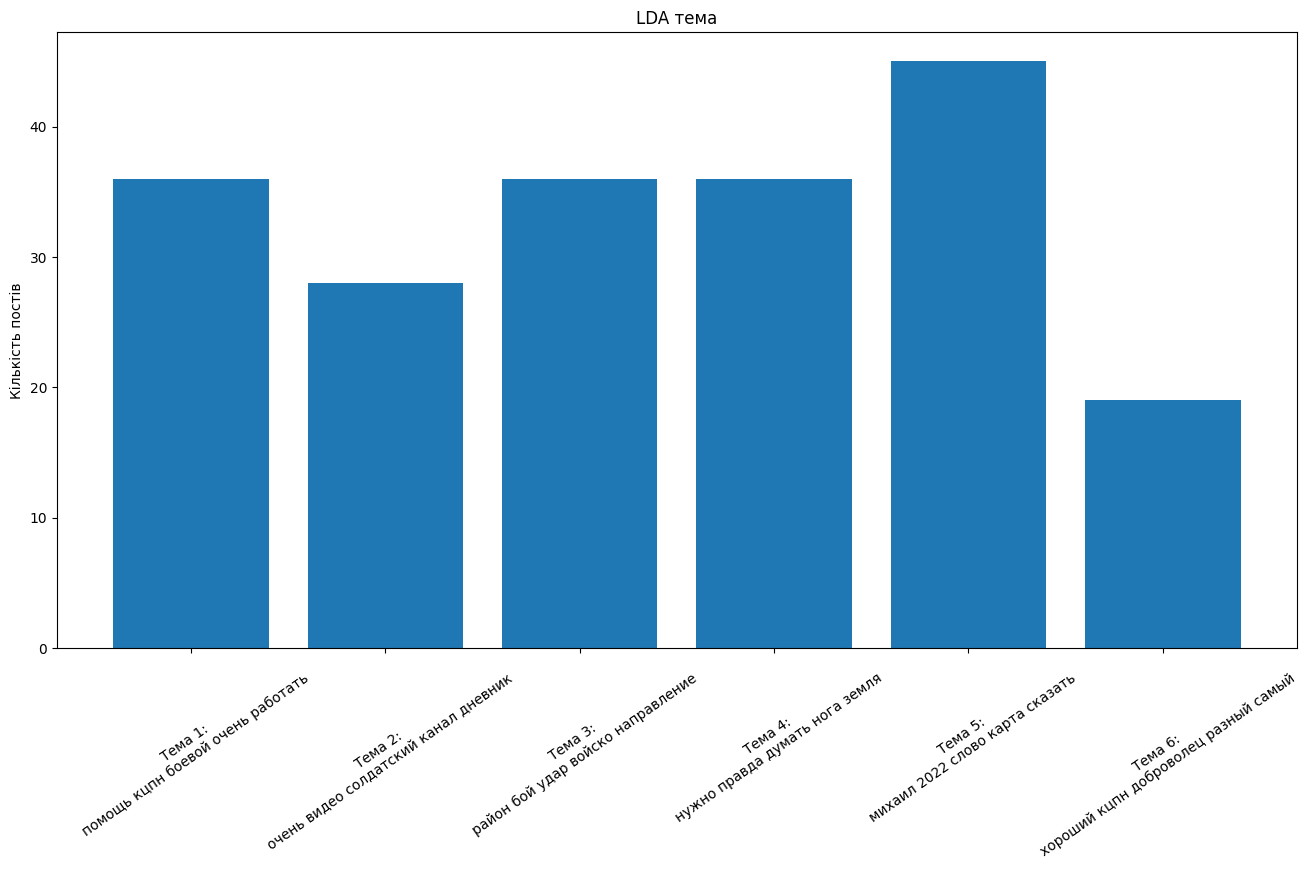

In [56]:
top_3_words = get_top_n_words(5, lda_keys, small_document_term_matrix, small_count_vectorizer, n_topics)
labels = ['Tема {}: \n'.format(i+1) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA тема');
ax.set_ylabel('Кількість постів');
plt.xticks(rotation = 35) 

In [57]:
labels

['Tема 4: \nнужно правда думать нога земля',
 'Tема 3: \nрайон бой удар войско направление',
 'Tема 5: \nмихаил 2022 слово карта сказать',
 'Tема 2: \nочень видео солдатский канал дневник',
 'Tема 1: \nпомощь кцпн боевой очень работать',
 'Tема 6: \nхороший кцпн доброволец разный самый']

In [58]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.614687
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.371841
[t-SNE] KL divergence after 1450 iterations: 0.039726


In [59]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer, n_topics)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [60]:
reindexed_data = reindexed_data.dropna()

## LDA, велика вибірка, візуалізація через heatmap

In [61]:
big_sample_size = 800
n = 10
big_count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=40000)
big_text_sample = reindexed_data.sample(n=big_sample_size, random_state=1).values
big_document_term_matrix = big_count_vectorizer.fit_transform(big_text_sample)



big_lda_model = LatentDirichletAllocation(n_components=n, learning_method='online', 
                                          random_state=3, verbose=0)
#big_lda_model.fit(big_document_term_matrix);
lda_topic_matrix = big_lda_model.fit_transform(big_document_term_matrix)

lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)



ValueError: Cannot take a larger sample than population when 'replace=False'

In [62]:
top_3_words = get_top_n_words(3, lda_keys, big_document_term_matrix, big_count_vectorizer,n)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA тема');
ax.set_ylabel('Кількість постів');
plt.xticks(rotation = 35) 

NameError: name 'big_document_term_matrix' is not defined

In [63]:
def keys_to_counts2(keys,n):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    dict = {pair[0]:pair[1] for pair in count_pairs}
    counts, categories = [],[]
    for i in range(0,n):
        if i in dict:
            counts.append(dict[i])
            categories.append(i)
        else:
            counts.append(0)
            categories.append(i)
    return (categories, counts)

In [64]:
def plot_heatmap_by_month(month, data, vectorizer):
    month_data = []
    n = 10
    d = data[data.index.month== month]
    for i in range(1,30):
        month_data.append(d[d.index.day == i].values)

    month_topic_matrices = []
    for m in month_data:
        document_term_matrix = vectorizer.transform(m)
        topic_matrix = big_lda_model.transform(document_term_matrix)
        month_topic_matrices.append(topic_matrix)

    month_keys = []
    for topic_matrix in month_topic_matrices:
        month_keys.append(get_keys(topic_matrix))
    month_counts = []
    for keys in month_keys:
        categories, counts = keys_to_counts2(keys,  n)
        month_counts.append(counts)
        

    topic_counts = pd.DataFrame(np.array(month_counts), index=range(1,30))
    topic_counts.columns = ['Topic {}'.format(i+1) for i in range(n)]

    return topic_counts


In [65]:
month_topic_counts = plot_heatmap_by_month(9,reindexed_data,  big_count_vectorizer)
month_topic_counts

NotFittedError: Vocabulary not fitted or provided

NameError: name 'month_topic_counts' is not defined

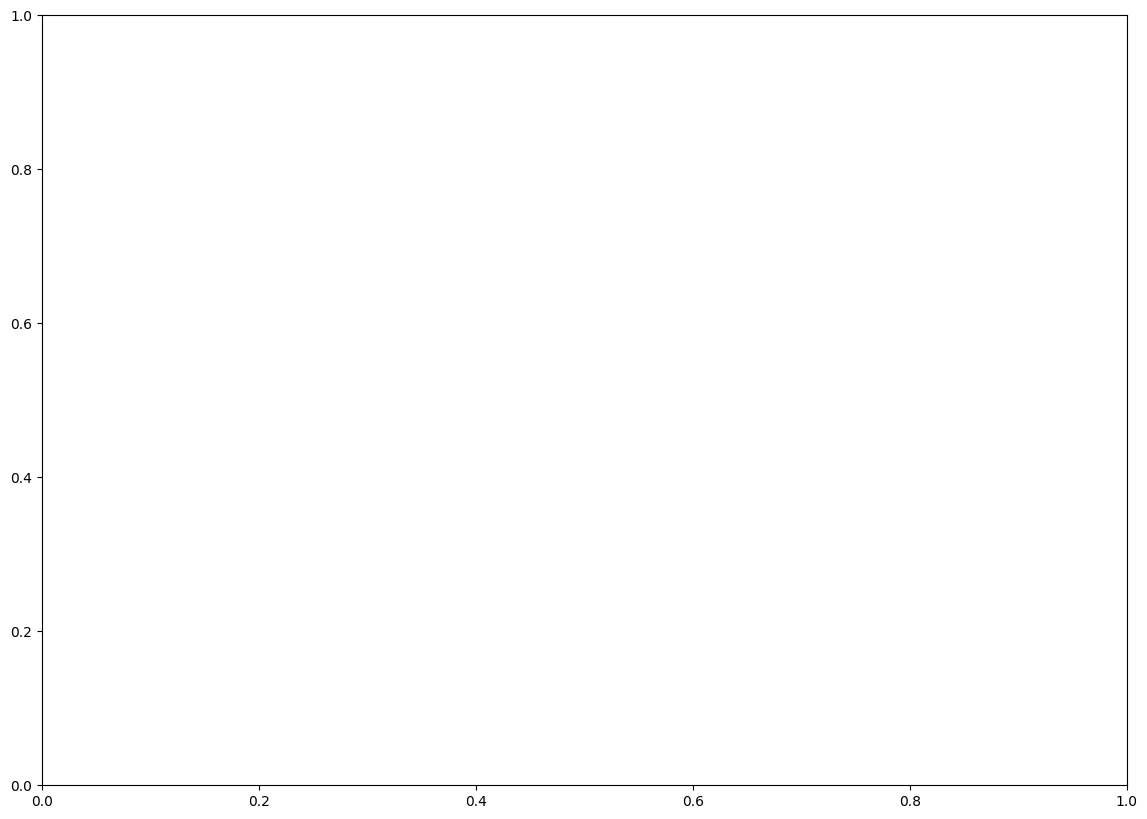

In [66]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(month_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()